In [1]:
# Setup CSS Styles
from plnbstyles import style_nb
style_nb("./styles.css")

<div id="ps-header">
    <a href="https://developers.planet.com/" target="_blank">
<img src="https://www.planet.com/assets/logos/logo.svg" style="display:inline-block; margin-right: 10px;" width="100"/> <span style="font-size:18px">Developer Resource Center</span>
</a>
    
###  Planet Analytics API Tutorial

<h1 style="margin-top:10px;">Planet Analytic Feeds Results</h1>
</div>
<div class="content-block">

## Overview

1. [Introduction](#1.-Introduction) 

> Introduction to Analytic Feed Results types: Object Detection vs Segmentation

2. [Getting Results](#1.-Getting-Results) 

> Get Results for a Subscription from the API

3. [Working with Planet Analytics Results](#3.-Working-with-Planet-Analytics-Results) 

> Interpret and visualize Results with source satellite imagery

4. [Segmentation Results](#4.-Segmentation-Results)

> Visualizing Segementation masks

</div>

## 1. Introduction

In the previous notebook, we explored the Planet Analytics Feeds API mechanics and core concepts of **Feeds** and **Subscriptions**. We worked through making requests to the api, understanding the response data, and showed how to create some basic visualizations with the data. It's encouraged to work through the first notebook before continuing.

In this notebook, we'll focus on Planet Analytic Feeds **Results**. Results represent the "detections" made in source Planet satellite imagery scenes for different types of objects visible on the ground. 

### Analytic Feed Results

**Results** on the Planet Analytics API represent the output or "detections" of our machine learning models. Results are created for each Subscription, and each Subscription is derived from a Feed:

*Feed → Subscription → Results* 

> When new Planet imagery is published that intersects a Subscription's AOI and TOI, Planet’s computer vision models process the imagery and the output is added to a "collection" (WFS 3) of Results associated with a Subscription.


#### Feed / Result Types

As we've seen, several types of **Feeds** exist, and Results for Feed Subscriptions can be categorized as one of two types: `Object Detection` and `Segmentation`.

<div class="callout-blue top-margin">

#### Types of Feeds + Result Output Format

| Feed Type | Results Type | Results Format | Results Access |
| --- | --- | --- | --- |
| Vessel Detection | Object Detection | Detection Features (Polygons) | WFS 3 (Detection Features) |
| Building Detection | Segmentation (Classification) | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |
| Road Detection | Segmentation (Classification) | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |

</div>

Outputs for **all** Results (of any Feed type) are delivered via `WFS 3` compliant endpoint on the API. The "shape" of the data representing Results for each Subscription are specific to the Subscription's Feed. 

*Object Detection** type Feeds Results output are returned as `GeoJSON Features` with polygonal geometries representing bounding boxes around detections made by the machine learning model. For example, a box around a ship. 

*Segmentation* type Feeds Results output are `GeoJSON Features` that describe "Quads" (individual raster files) that make up a larger segmentation / classification "mask". The Planet Analytics API lists links to these segmentation quads on the Planet Mosaics API where the raster files are stored, but also links to XYZ basemap tiles that can be used to view the raster data.

### WFS 3


<img src="http://www.opengeospatial.org/pub/www/files/OGC_Logo_2D_Blue_x_0_0.png" align="right" style="margin-left: 20px" width="100"></img>

The Planet Analytics API's **Results** (`collections` and `items`) endpoints follow the [Open Geospatial Consortium's](http://www.opengeospatial.org) (OGC) [Web Feature Service 3.0](https://github.com/opengeospatial/WFS_FES) (WFS) specification.


> A Web Feature Service (WFS) is a standard API that represents collections of geospatial data.

</div>

## 2. Getting Results

Let's get started by accessing one of our Subscriptions. We'll see how we can get it's associated **Results** and we'll explore and visualize the data!

First we'll setup our API `base url` and `authentication` so we can make our `request`, just like in the previous tutorial.

In [2]:
import os

# Configure Auth and Base Url

# Planet Analytics API base url
PAA_BASE_URL = "https://api.planet.com/analytics/"

# API Key Config
API_KEY = os.environ['PL_API_KEY']

# Setup Auth
BASIC_AUTH = (API_KEY, '')

We'll make a couple helper functions for "pretty printing" our responses:

In [3]:
# Pretty Print Helper
import pprint
pp = pprint.PrettyPrinter(indent=4)

# JSON Pretty Print Helper
import json

def jpp(data):
    print(json.dumps(data, indent=4))

Now let's use the `Requests` library to get the Subscription. We'll get the Subscription using it's `id`, which is a ["Universally Unique Identifier](https://en.wikipedia.org/wiki/Universally_unique_identifier) (UUID) string. 

*Remember, we can see a list of available Subscriptions (and their `ids` by making a request to the `/subscriptions` endpoint. See the previous tutorial for more details.*

In [4]:
# Request a Subscription

import requests

# Define the Subscripton UUID
subscription_id = "9db92275-1d89-4d3b-a0b6-68abd2e94142"

# Construct the url for the Subscription
subscription_url = PAA_BASE_URL + 'subscriptions/' + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscriptions list 
subscription = requests.get(subscription_url, auth=BASIC_AUTH).json()

Request URL: https://api.planet.com/analytics/subscriptions/9db92275-1d89-4d3b-a0b6-68abd2e94142


Let's take a look at the Subscription we just requested:

In [5]:
# Print some data
print("{} \n{}\nSubscription Id: {}\n".format(subscription['title'], subscription['description'], subscription['id']))

# Print the subscription object
print(json.dumps(subscription, sort_keys=True, indent=4))

Port of Oakland, USA 
Daily Vessel Detection
Subscription Id: 9db92275-1d89-4d3b-a0b6-68abd2e94142

{
    "created": "2019-04-11T18:03:18.890Z",
    "description": "Daily Vessel Detection",
    "endTime": "2019-07-01T00:00:00.000Z",
    "feedID": "1b4c9ee2-699b-4621-bb4f-934eda8090b5",
    "geometry": {
        "coordinates": [
            [
                [
                    -122.355422973633,
                    37.7517152984565
                ],
                [
                    -122.243843078613,
                    37.7517152984565
                ],
                [
                    -122.243843078613,
                    37.838530034214
                ],
                [
                    -122.355422973633,
                    37.838530034214
                ],
                [
                    -122.355422973633,
                    37.7517152984565
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "9db92275-1d89-4d3b-a0b6-6

The above output should look familiar from the previous tutorial. We see the title, AOI, TOI, and other metadata about the Subscription.

Now we can move on to getting the **Results** for this Subscription:

#### Subscription Results Collection

We can use the Subscription `id` property to get the **Results** `collection` and `items` for this Subscription.

We can get the `collection` by making a request to the `/collections` endpoint with the `id` from our Subscription:

In [6]:
# Construct the url for the subscription's Results collection
subscription_results_url = PAA_BASE_URL + 'collections/' + subscription['id']

print("Request URL: {}".format(subscription_results_url))

# Get subscription results collection
subscription_results = requests.get(subscription_results_url, auth=BASIC_AUTH).json()

# Pretty Print reponse json
print(json.dumps(subscription_results, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142
{
    "created": "2019-04-11T18:03:18.890Z",
    "description": "Daily Vessel Detection",
    "links": [
        {
            "href": "https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142",
            "rel": "self"
        },
        {
            "href": "https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items",
            "rel": "items"
        },
        {
            "href": "https://api.planet.com/analytics/collections",
            "rel": "collections"
        },
        {
            "href": "https://api.planet.com/analytics/subscriptions/9db92275-1d89-4d3b-a0b6-68abd2e94142",
            "rel": "subscription"
        },
        {
            "href": "https://api.planet.com/analytics/feeds/1b4c9ee2-699b-4621-bb4f-934eda8090b5",
            "rel": "feed"
        }
    ],
    "name": "9db92275-1d89-4d3b-a0b6-68abd2e94142",
 

#### Subscription Results Items

Now let's get the actual **Results** `items` from the `collection`. Our request endpoint should be constructed in like this: `/collections/{ID}/items`

But we don't need to construct the **Results** `items` url manually, it's one of the `links` that's provided in our Subscription response. Let's use the link from our Subscription response from the previous cell:

In [7]:
# Construct the url
subscription_items_url = list(filter(lambda link: link['rel'] == 'results', subscription['links']))[0]['href']

print("Subscription Items URL:\n{}\n".format(subscription_items_url))

Subscription Items URL:
https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items



We'll use the `url` to make our request:

In [8]:
# Request subscription Items

# Get request Subscription features (collection items)
subscription_items = requests.get(subscription_items_url, auth=BASIC_AUTH).json()

# Pretty Print reponse json
print("Subscription Results Collection Items: (GeoJSON FeatureCollection):\n {}".format(json.dumps(subscription_items, sort_keys=True, indent=4)))


Subscription Results Collection Items: (GeoJSON FeatureCollection):
 {
    "features": [
        {
            "created": "2019-04-18T00:08:37.176Z",
            "geometry": {
                "coordinates": [
                    [
                        [
                            -122.352849334526,
                            37.8268243340292
                        ],
                        [
                            -122.352854839451,
                            37.8261939909461
                        ],
                        [
                            -122.353740098692,
                            37.8261988516813
                        ],
                        [
                            -122.353734601296,
                            37.8268291948741
                        ],
                        [
                            -122.352849334526,
                            37.8268243340292
                        ]
                    ]
                ],
    

Nice! Now we've got our first set of **Results** data. The **Results** for a Subscription come to us as a `GeoJSON` `FeatureCollection`.

Each `item` is a `GeoJSON Feature` listed in the the `features` property of the `FeatureCollection`. Let's check how many `items` (Features) we have so far:

In [9]:
# Print the number of Features in the subscription's collection:
print("\nNumber of Items (Features): {} \n".format(len(subscription_items['features'])))


Number of Items (Features): 250 



The request we made to get these `items` is actually a **paged** list of results. 

In our `GeoJSON` Feature Collection, we see there is a `links` property, which conforms to the [WFS 3.0 Spec](https://github.com/opengeospatial/WFS_FES/blob/master/core/openapi/schemas/featureCollectionGeoJSON.yaml#L14) in accordance with the [OpenAPI spec for Links](https://swagger.io/docs/specification/links/). 

Let's look at the `links` property to see how we can get all the **Results** `items` for our Subscription:

In [10]:
# Pretty Print the links
pp.pprint(subscription_items['links'])

[   {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items',
        'rel': 'self'},
    {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142',
        'rel': 'collection'},
    {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=80bf291a-fb89-4eee-81e0-0bd321461088',
        'rel': 'next'}]


The `"rel" : "next"` property's `href` should contain a URL with a [`query string`](https://en.wikipedia.org/wiki/Query_string) `?before={ITEM_ID}` where the `ITEM_ID` is the UUID identifier.

We can use the `link` with the `rel` value "`next`" to get the next page of data, and follow each subsequent `next` link to request all the pages of data and get the entire `FeatureCollection` for this subscription's items. 

Let's write a helper function to do this:

In [11]:
# Helper to get the "next" link
def get_next_link(links):
    for link in links:
        if link['rel'] == 'next':
            return link['href']

We can use our helper function to get the first "next" link:

In [12]:
# Get the first "next" link
next_link =  get_next_link(subscription_items['links'])
page_number = 2   

print(next_link)

https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=80bf291a-fb89-4eee-81e0-0bd321461088


Now let's iterate through our data and follow each "next" link to get all the data associated with our Subscription's Resuts Collection.

In [13]:
# Loop to get all pages of features
while next_link:
    print("Getting page number {} at {}".format(page_number, next_link))
    
    # Use "next" link to request next page
    next_collection = requests.get(next_link, auth=BASIC_AUTH).json()
        
    print("Found {} additional Features \n".format(len(next_collection['features'])))
    
    # Get the next "next" link
    next_link = get_next_link(next_collection["links"])

    # Add features from new page to our original list of features
    subscription_items['features'].extend(next_collection['features'])
    
    # increment the page number
    page_number + 1
    
print("Total Subscription Items: {}".format(len(subscription_items['features'])))  

Getting page number 2 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=80bf291a-fb89-4eee-81e0-0bd321461088
Found 250 additional Features 

Getting page number 2 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=b5ef9b24-ab0f-429c-8237-57ee1dd5fc8f
Found 250 additional Features 

Getting page number 2 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=7a3004ab-b111-4080-a580-c1318fe1c7fd
Found 33 additional Features 

Total Subscription Items: 783


We can also increase the number of results returned (default 250, max 10000) 
by changing the limit query parameter on the number of results that are returned:

`requests.get(subscription_items_url, params={"limit": 500} )`

Here's our final **Results** `FeatureCollection`:

In [14]:
# Now we have our complete GeoJSON Feature Collection
subscription_items

{'features': [{'created': '2019-04-18T00:08:37.176Z',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-122.352849334526, 37.8268243340292],
      [-122.352854839451, 37.8261939909461],
      [-122.353740098692, 37.8261988516813],
      [-122.353734601296, 37.8268291948741],
      [-122.352849334526, 37.8268243340292]]]},
   'id': '946bc777-24e5-413d-b1a4-40e61a766e9e',
   'links': [{'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items/946bc777-24e5-413d-b1a4-40e61a766e9e',
     'rel': 'self'},
    {'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items/946bc777-24e5-413d-b1a4-40e61a766e9e/resources/source-image-info',
     'rel': 'source-image-info'}],
   'properties': {'_g4_task_instance_id': 'taski_01D8PVXESYCMGVA6GGEKWEMY52',
    '_object_class_idx': 1,
    'model_id': '01D3FJCDHEZ1JS56150B7YR8VT',
    'model_version': '2019-03-29T21:01:06Z',
    'object_area_m2': 5449.148593040718,
    'o

## 3. Working with Planet Analytics Results

Now that we've got our **Results** let's use use GeoPandas to explore our data like we did in the previous tutorial.

In [15]:
import geopandas as gpd
import pandas as pd

# Make a GeoPandas data frame from our collection items
# Since we're importing a GeoJSON file, we can use the `from_features` method
gdf = gpd.GeoDataFrame.from_features(subscription_items['features'])

# Show the first five results from our GeoDataFrame
gdf.head()

_g4_task_instance_id  _object_class_idx  \
0  taski_01D8PVXESYCMGVA6GGEKWEMY52                  1   
1  taski_01D8PVXESYCMGVA6GGEKWEMY52                  1   
2  taski_01D8PVXESYCMGVA6GGEKWEMY52                  1   
3  taski_01D8PVXESYCMGVA6GGEKWEMY52                  1   
4  taski_01D8PVXESYCMGVA6GGEKWEMY52                  1   

                                            geometry  \
0  POLYGON ((-122.352849334526 37.8268243340292, ...   
1  POLYGON ((-122.353777569274 37.829705396547, -...   
2  POLYGON ((-122.350768725481 37.8299268180054, ...   
3  POLYGON ((-122.308555043989 37.8208149083311, ...   
4  POLYGON ((-122.333441481561 37.8106885658888, ...   

                     model_id         model_version  object_area_m2  \
0  01D3FJCDHEZ1JS56150B7YR8VT  2019-03-29T21:01:06Z     5449.148593   
1  01D3FJCDHEZ1JS56150B7YR8VT  2019-03-29T21:01:06Z     5966.122340   
2  01D3FJCDHEZ1JS56150B7YR8VT  2019-03-29T21:01:06Z     4417.449102   
3  01D3FJCDHEZ1JS56150B7YR8VT  2019-03-29T21:01:06Z     3794.869141   
4  01D3FJCDHEZ1JS56150B7YR8VT  2019-03-29T21:01:06Z    16961.539111   

   object_diagonal_m  object_length_m  object_width_m  \
0         104.698790        77.911448       69.940281   
1         109.237758        77.642691       76.840746   
2         103.599343        91.724932       48.159742   
3         105.457226        98.107177       38.680851   
4         188.308255       151.305127      112.101549   

                      observed     score source_asset_type  \
0  2019-04-17T18:28:13.113392Z  0.997806            visual   
1  2019-04-17T18:28:13.113392Z  0.995018            visual   
2  2019-04-17T18:28:13.113392Z  0.988806            visual   
3  2019-04-17T18:28:13.113392Z  0.950957            visual   
4  2019-04-17T18:28:13.113392Z  0.938942            visual   

   source_cloud_cover           source_item        source_item_id  \
0                0.19  20190417_182813_0e3a  20190417_182813_0e3a   
1                0.19  20190417_182813_0e3a  20190417_182813_0e3a   
2                0.19  20190417_182813_0e3a  20190417_182813_0e3a   
3                0.19  20190417_182813_0e3a  20190417_182813_0e3a   
4                0.19  20190417_182813_0e3a  20190417_182813_0e3a   

  source_item_type  xmax_px  xmin_px  ymax_px  ymin_px  
0     PSScene3Band     7496     7470     2660     2637  
1     PSScene3Band     7468     7443     2557     2531  
2     PSScene3Band     7556     7526     2538     2522  
3     PSScene3Band     8797     8784     2883     2850  
4     PSScene3Band     8070     8019     3267     3230

When we created the DataFrame with the `.from_features()` method, GeoPandas automatically converted our `GeoJSON` geometries to `Shapely` shapes.

### Result Item Properties

Let's take a look at the rest of the columns available to us:

In [16]:
# List the item properties (columns)
for column in gdf.columns.values:
    print(column)

_g4_task_instance_id
_object_class_idx
geometry
model_id
model_version
object_area_m2
object_diagonal_m
object_length_m
object_width_m
observed
score
source_asset_type
source_cloud_cover
source_item
source_item_id
source_item_type
xmax_px
xmin_px
ymax_px
ymin_px


Most of these properties should be self-explanatory, and different Feed types may include different properties.

##### Source Properties
The `source_` properties all relate to the source satellite imagery that the detections were made against. We'll see how we can use these later on.

##### Detection Object Properties
The `object_` properties describe some meta-data about each detection, like length and diagonal. 

Also relevant are `measure`, `score` (the score assigned by the machine learning model), `geometry` (the "footprint" of the detection), and `observed`.

Let's convert our `observed` column data to a `datetime`. The `observed` column represents the date that a detection was made, based on when the source satellite image was taken.

In [17]:
# Convert observed column into a datetime datatype
gdf["observed"] = pd.to_datetime(gdf["observed"])

Let's visualize our **Results**. For starters, we can create a simple plot using GeoPandas built in `plot` method. Later on we'll make some more intersting interactive visualizations.

In [18]:
# Simple GeoPandas Plot of features
gdf.plot()

### Inspecting a single detection
We can use our GeoPandas GeoDataFrame to look at the first detection item. 

In [19]:
# Select the first detection by index
first_detection = gdf.iloc[0]
first_detection

_g4_task_instance_id                     taski_01D8PVXESYCMGVA6GGEKWEMY52
_object_class_idx                                                       1
geometry                POLYGON ((-122.352849334526 37.8268243340292, ...
model_id                                       01D3FJCDHEZ1JS56150B7YR8VT
model_version                                        2019-03-29T21:01:06Z
object_area_m2                                                    5449.15
object_diagonal_m                                                 104.699
object_length_m                                                   77.9114
object_width_m                                                    69.9403
observed                                 2019-04-17 18:28:13.113392+00:00
score                                                            0.997806
source_asset_type                                                  visual
source_cloud_cover                                                   0.19
source_item                           

Lets look at the first detection's geometry visually. When we created our GeoDataFrame from our collection items data, the features were automatically converted to Shapely Geometries:

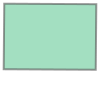

In [20]:
# Use shapely to show the first geometry
first_detection['geometry']

#### Visualizing Results with GeoViews

That's simple enough, but doesn't really give us much context. Let's use [GeoViews](http://geo.holoviews.org) to make some more interesting interactive visualizations!


<div class="callout-light top-margin">
    
<img src="http://geo.holoviews.org/_static/geoviews-logo.png" align="right" style="margin-left: 20px" width="100"></img>


GeoViews is built on [HoloViews](http://holoviews.org/) and uses [Cartopy](http://scitools.org.uk/cartopy), [matplotlib](http://matplotlib.org/) and [Bokeh](http://bokeh.pydata.org/) for visualizations. It is released as part of the [PyViz](http://pyviz.org/) suite.

> GeoViews is a Python library that makes it easy to explore and visualize geographical, meteorological, and oceanographic datasets, such as those used in weather, climate, and remote sensing research.

</div>

We can import GeoViews and it's parent library HoloViews like this:

/home/orestis/.applications/anaconda3/envs/planet-notebooks/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/orestis/.applications/anaconda3/envs/planet-notebooks/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
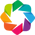

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
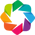

In [21]:
# Import GeoViews
import geoviews as gv

# Import HoloViews
import holoviews as hv
from holoviews import opts as hvOpts

# Set rendering backends
gv.extension('bokeh')
hv.extension('bokeh')

In [22]:
# Create a basemap to use in our visualizations
basemap = gv.tile_sources.CartoLight

# List built in GeoViews tile sources 
# help(gv.tile_sources)

Now let's plot the detection geometry on a basemap:

In [23]:
# Plot the detection using GeoViews Shape element with a basemap
gv.Shape(first_detection['geometry']).opts(padding=0.5, width=500, height=400) * basemap

:Overlay
   .Shape.I :Shape   [Longitude,Latitude]
   .WMTS.I  :WMTS   [Longitude,Latitude]

Nice! GeoViews natively handles our Shapely Geometries and has no issue plotting our detection using an interative map with Bokeh. 

If we zoom out a bit, we can start to get some more context by seeing where the detection occurred on the map.

**In the next section, we'll take a look at combining Planet Analytics Data with Planet Imagery**

### Analytics Detections and  Source Imagery

The metadata associated with a single detection contains some interesting information, but of course we're here because we want to see the detection with our own eyes too! 

We can easily access the satellite imagery data associated with each detection via several of Planet's [Data API](https://developers.planet.com/docs/api/) and [Tile services](https://developers.planet.com/docs/api/tile-services/), and we'll be able to view `metadata`, and `imagery previews` if we like, as well as download the imagery `assets`. 

In order to find the image, we'll need the `scene id` and [`item_type`](https://developers.planet.com/docs/api/items-assets/) (sensor type) for the satellite image used to observe the detection.

In our analytics detections data, sensor type is stored as the `source_item_type` property, and scene id is stored as the `source_item_id`. 

**Let's get this information for a single detection from our subscription data:**

In [24]:
# Get the sensor type
item_type = first_detection['source_item_type']

# Get the item id
scene_id = first_detection['source_item_id']

print("Item Type: {} \nScene Id: {}".format(item_type, scene_id))

Item Type: PSScene3Band 
Scene Id: 20190417_182813_0e3a


### Getting observation source imagery data

Using just these two peices of information, we can access everything we need to know about the satellite imagery used in the observation by getting it from Planet's Data API! 

We'll use the [Planet Python Client](https://planetlabs.github.io/planet-client-python/) in this example, but you can also make a request to the API directly with your preferred approach by constructing a url that includes the `item_id` and `item_type`:

`https://api.planet.com/data/v1/item-types/{ITEM TYPE}/items/{ITEM ID}`

For more in depth guides on working with the Planet Data API, visit our [Planet School](https://developers.planet.com/planetschool/) section on the Planet [Developer Resource Center](https://developers.planet.com) website.

We can get information on our source satellite imagery scene by using the `get_item` method from the Planet Python Client:

In [25]:
# Import the Planet Data Api module
from planet import api as PlanetAPI

# Create a client for the API
planet_client = PlanetAPI.ClientV1(api_key=API_KEY)

# Get data for our item
source_scene = planet_client.get_item(item_type, scene_id).get()

# Pretty Print our scene info
jpp(source_scene)

INFO:planet.api.dispatch:GET https://api.planet.com/data/v1/item-types/PSScene3Band/items/20190417_182813_0e3a None None


{
    "_links": {
        "_self": "https://api.planet.com/data/v1/item-types/PSScene3Band/items/20190417_182813_0e3a",
        "assets": "https://api.planet.com/data/v1/item-types/PSScene3Band/items/20190417_182813_0e3a/assets/",
        "thumbnail": "https://tiles.planet.com/data/v1/item-types/PSScene3Band/items/20190417_182813_0e3a/thumb"
    },
    "_permissions": [
        "assets.analytic_xml:download",
        "assets.basic_analytic_dn:download",
        "assets.basic_analytic_dn_xml:download",
        "assets.basic_analytic_xml:download",
        "assets.analytic_dn:download",
        "assets.basic_udm:download",
        "assets.analytic:download",
        "assets.visual:download",
        "assets.analytic_dn_xml:download",
        "assets.basic_analytic_rpc:download",
        "assets.basic_analytic_dn_rpc:download",
        "assets.visual_xml:download",
        "assets.basic_analytic:download",
        "assets.udm:download"
    ],
    "geometry": {
        "coordinates": [
   

The result should be a `GeoJSON Feature` with the following noteable fields: 

* The scene metadata in `properties`
* The scene footprint in `geometry`
* Links to the scene imagery assets and previews in `_links` 

#### Source Imagery Previews and Visualizations

Let's actually view the scene viually by using the [`thumbnail`](https://developers.planet.com/docs/api/item-previews) link to preview our scene imagery with IPython:

In [26]:
from IPython.display import Image

# Get the thumbnail url
# Append our api key to authenticate
thumb_url = source_scene['_links']['thumbnail'] + '?api_key=' + API_KEY

# Render the preview image with IPython.display
Image(url=thumb_url)

There's a nice preview of our image, so we can take a peek without having to download the entire asset!

But we won't need to get all the scene meta data available on the Planet Data Api just to see the preview. We only really need the `item_type` and `scene_id` to construct urls for the scene image preview thumbnail, as well as (`xyz`) [tiles](https://developers.planet.com/docs/api/tile-services) we can use in a web map.

The urls to these imagery previews look like:

* Thumbnails: `https://tiles.planet.com/data/v1/item-types/{ITEM TYPE}/items/{ITEM ID}/thumb`
* XYZ Tiles: `https://tiles.planet.com/data/v1/{ITEM TYPE}/{ITEM ID}/{Z}/{X}/{Y}.png`

Let's write a helper function that will let us grab the source imagery that our detections were observed in:

In [27]:
# Get source imagery helper utility
# Takes type xyz or thumb
def get_source_imagery_url(scene_id, scene_sensor, preview_type="xyz"):
    
    # Determine parts of url
    prefix = "" if preview_type == "xyz" else "item-types/"
    middle = "/" if preview_type == "xyz" else "/items/" 
    suffix = "/{Z}/{X}/{Y}.png" if preview_type == "xyz" else "/thumb"
    
    # Construct the url
    source_imagery_url = "https://tiles.planet.com/data/v1/" + prefix + scene_sensor + middle + scene_id + suffix + "?api_key=" + API_KEY
    return source_imagery_url

Using our helper function, we can construct the preview urls:

In [ ]:
from IPython.core.display import HTML

# Get the scene thumbnail url
thumb_url = get_source_imagery_url(scene_id, item_type, 'thumb')

# Get the scene tiles url
tiles_url = get_source_imagery_url(scene_id, item_type, 'xyz')

# Print the tile url
print("XYZ Web Map Tiles Url:\n{}\n".format(tiles_url))

# Print the thumbnail link
print("Thumbnail URL:")
HTML('<a href="{}" target="_blank">Thumbnail Url</a>'.format(thumb_url))


#### View a single detection with it's source Planet Imagery

Let's put our preview images to work by overlaying a detection on a web map with the observation imagery xyz tiles:

In [ ]:
# Plot the detection geometry
single_detection = gv.Shape(first_detection['geometry'], label="Detection in {} - {}".format(item_type, scene_id)).opts(
    fill_alpha=0, 
    line_color="red", 
    width=600, height=500, padding=3,
)

# Plot with web map tiles
single_detection * basemap * gv.WMTS(data=tiles_url)

We now have an interactive map with our detection geometry and Planet source imagery. Pan around the map to see more of the scene!

### Visualize All Detections 

#### Detection Thumbnails

Let's use this same method to create thumbnails to view more detections with their source imagery. Let's create a function to render these visualizations:

In [ ]:
# Helper function to render a thumbnail for an item
# Takes an index (row) from DataFrame
def render_item_thumb(index):
    # Get the item row from DataFrame
    item = gdf.iloc[index]
    
    # Construct tile url
    tile_url = get_source_imagery_url(item['source_item_id'], item['source_item_type'], 'xyz')   
    
    # Create detection plot
    detection = gv.Shape(item['geometry']).opts(
        fill_alpha=0, 
        line_color="red", 
        width=200, height=200,
        default_tools=[],
        xaxis=None,
        yaxis=None
    ) 
    
    return (detection * basemap * gv.WMTS(data=tile_url))

Now let's use our helper function to render a Holoviews `Layout`. We'll render the first twenty detections:

In [ ]:
# Iterate through the first 20 thumbs
thumbs_list = [render_item_thumb(i) for i in list(gdf.index[0:20])]

# Create a Layout visualization
layout = hv.Layout(thumbs_list).opts(shared_axes=False).cols(4)
layout

#### Interactive Detections Plot

Using GeoViews, we can also plot all our detections on a single interactive map and color our detections based on their `score` values. 

We can include a histogram using the `.hist` method on our GeoViews `Polygons` element to show a break down of overall scores.

In [ ]:
# Plot all features on a map

# Pick the properties (dimensions) we want to include
items_dimensions = ['score', 'object_diagonal_m', 'observed']

# Plot the features with GeoViews
all_features_plot = gv.Polygons(gdf, vdims=items_dimensions).opts(
    colorbar_position="bottom", colorbar_opts={"title": "score"},
    cmap="RdYlBu_r", 
    width=600, height=500,
    colorbar=True,
    title="All Detections for {}".format(subscription['title']))

# Plot the features map with a histogram and basemap 
all_features_plot.hist() * basemap

We can transform our polygons into points using the `.to` method:

In [ ]:
all_points = all_features_plot.to(gv.Points, vdims=['score'])
all_points.options(width=800, height=600) * basemap

#### Handling Large Datasets
We can even handle millions of data points using the [Datashader](http://holoviews.org/user_guide/Large_Data.html) operation from HoloViews. Here we'll render our features as points (centroid of polygons) using Datashader:

In [ ]:
from holoviews.operation.datashader import datashade
from colorcet import fire

(datashade(all_points, cmap=fire, width=800, height=600) * basemap).options(width=800, height=500, title="Datashaded Points")

#### Visualize All Detections with Planet Imagery

Now lets combine these plots with our source satellite imagery, as we did earlier for a single detection.

It will be useful to know the overall "bounds" of our data. We can get this with GeoPandas:

In [ ]:
# Get the plot bounds
bounds = tuple(gdf.total_bounds)
bounds

Our Subscription's **Results** collection may have hundreds or thousands of detection items... Let's use a Holoviews [`DynamicMap`](http://holoviews.org/reference/containers/matplotlib/DynamicMap.html) to create an interactive webmap that will let us click on any detection data point and render the imagery in an adjacent plot. This will be great for reducing the visual clutter that would result in rendering all the detections' observation scenes at the same time.

The code in the next cell uses some more advanced `HoloViews` concepts like [`Select1D streams`](http://holoviews.org/reference/streams/bokeh/Selection1D.html) and [`Ndoverlay`](http://holoviews.org/reference/containers/bokeh/NdOverlay.html), and DynamicMaps to make an interactive visualization: 

In [ ]:
# Interactive Detection Viewer using GeoViews DynamicMap

from holoviews.streams import Selection1D
from shapely.geometry import box, Polygon

# Master plot
masterplot = all_features_plot.options(
    fill_alpha=0, nonselection_line_alpha=0.1, line_color="score",  selection_line_color="green",
    tools=["hover", "tap", "save", "reset"], toolbar="above")

# Define our stream (responds to Tap event from our master plot)
selection_stream = Selection1D(source=masterplot, transient=True)
    
# Callback Function for DynamicMap to render selection detail    
def render_selection(index):
    
    # Selection Size
    selection_plot_size = 300
    
    # Data Row Index
    # We only use the FIRST selection
    row_index = index[0] if index else 0
    
    # Get the detection data   
    detection_data = gdf.iloc[row_index]
    
    # Set the label to the detection id if we have a selection
    label = "Dectection: {}".format(row_index) if index else 'No Selection' 
    
    # Define the detection geometry (or use total bounds if no selection)
    detection_geometry =  detection_data['geometry'] if index else box(*bounds)
    
    # Get the Extent
    detail_extent = detection_geometry.bounds if index else bounds
    
    # Define the detection Shape
    detection_shape = gv.Shape(detection_geometry).opts(
        fill_alpha=0, line_alpha=0, 
        show_bounds=True, 
        toolbar="below",
        width=selection_plot_size, 
        height=selection_plot_size,
        default_tools=["pan", "wheel_zoom", "save",  "reset"])
    
    # Dict to hold our imagery layers
    imagery_layers = {
        # Define the basemap
        "basemap": gv.WMTS(basemap.data).opts(default_tools=[], width=selection_plot_size)
    }
    
    # Table data
    table_data = gdf.loc[[*index], ['score', 'source_item_type', 'source_item_id']]
    table_data['row'] = index
    
    # Create a Table with score data
    table = hv.Table(table_data, label="Selected Detections Properties (First is plotted)").opts(width=selection_plot_size)
    
    # Check if we have a selection
    if index:
                
        #Get the detection's imagery type and id
        detail_scene_id = detection_data['source_item_id']
        detail_scene_sensor = detection_data['source_item_type']

        # Get the imagery tile url
        image_tile_url = get_source_imagery_url(detail_scene_id, detail_scene_sensor, 'xyz')
        
        # Create the imagery tile layer
        detail_imagery = gv.WMTS(image_tile_url).opts(
            width=selection_plot_size, 
            height=selection_plot_size)
        
        # Add the imagery layer to our tile layers
        imagery_layers["imagery"] = detail_imagery
        
        # Style the detections box
        detection_shape.opts(fill_alpha=0, line_alpha=1, line_color="red")

    else:
        # Clear the imagery layer if nothing is selected
        if "imagery" in imagery_layers:
            imagery_layers.pop('imagery', None)
        
    # Create tile layers
    tiles = hv.NdOverlay(imagery_layers)
        
    # Create the detail layout
    detail_layout =  (detection_shape * tiles).opts(
        title=label, 
        fontsize={"title": "8pt"},
        xaxis=None, yaxis=None, 
        width=selection_plot_size, 
        height=selection_plot_size
    ) + table
        
    return detail_layout.cols(1)

# Create the selection plot using a DynamicMap
selection_plot = hv.DynamicMap(render_selection, streams=[selection_stream]).collate()

# Create the layout and set options
layout = (masterplot * basemap  + selection_plot).options(
    shared_axes=False, merge_tools=False, 
    fontsize={"title": "14pt"},
    title="Interactive Detections and Imagery")

# Show the layout
layout.cols(2)

#### Visualize by Time Dimension

We can also make a visualization that let's us interactively view detections for certain days using a HoloMap. First let's organize our data by day:

In [ ]:
# Bucket the data by time interval

# Set the interval
interval = "D" # W = Week, D = Day, Month = M

time_bucketed_data = gdf.set_index('observed')[[
    "source_item_id", 
    "geometry", 
    "source_cloud_cover", 
    "score"]].groupby([pd.Grouper(freq=interval)]).agg({
    'geometry': 'count', 
    'source_item_id': 'nunique', 
    'source_cloud_cover': "mean", 
    'score':'mean'
}).fillna(0).rename(index=str, columns={"geometry": "detection_count", "source_item_id": "imagery_count", "source_cloud_cover":"mean_cloud_cover", "score":"mean_score"})

# Remove rows without detections
time_bucketed_data = time_bucketed_data[time_bucketed_data["detection_count"] != 0]

Next let's define the render function to use for each day:

In [ ]:
from datetime import timedelta

# Render Features for a date
def plot_features_for_date(start_date):
    
    # Increment start date by one day
    end_date = start_date + timedelta(days=1)

    # Slice our data to only include features between start and end date
    mask = (gdf["observed"] > start_date) & (gdf["observed"] <= end_date)
    sliced_data = gdf.loc[mask]
    
    # Create the Polygons Plot
    return gv.Polygons(sliced_data, vdims=['score']).opts(fill_alpha=0, nonselection_line_alpha=0.1, line_color="score",  selection_line_color="green", cmap="RdYlBu_r", width=600, height=400, tools=["hover", "tap"], title="Detections for {} on {}".format(subscription['title'], start_date))


Finally let's create our plot:

In [ ]:
# Render HoloViews HoloMap for 

# Define the date dimension
kdims = [hv.Dimension(('start_date', 'Observation Date'))]

# Create all the plots
features_for_date = {(date): plot_features_for_date(date) for date in list(pd.to_datetime(time_bucketed_data.index))}

# Create the HoloMap 
features_by_day_plot = hv.HoloMap(features_for_date, kdims=kdims)

# Add a basemap to the features plot and render
features_by_day_plot * basemap

## 4. Segmentation Results

So far we've looked at an **Object Detection** Feed's Results. Let's switch over to a **Segmentation Feed** and see how we can work with the raster mask data. 

Since the output data for a Segmentation Feed is comprised of `mosaics` for each interval that we run our model, we can use the mosaics to visualize and explore our data.

We'll use the Subscription Information, and subsequently the Feed information to determine where the Raster Result basemaps are available using the [Planet Mosaics API](https://developers.planet.com/docs/api/reference/#tag/Basemaps-and-Mosaics). Later we'll see how we can get the actual raster data as well.

First let's get a new Subscription that uses a *Segmentation* Feed type using a Subscription Id:

In [ ]:
# Construct the url for a Segmentation Feed Subscription 
seg_subscription_url = PAA_BASE_URL + 'subscriptions/' + 'e0c33581-5080-4e81-98a1-2d555e91b41e'

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscription
seg_subscription = requests.get(seg_subscription_url, auth=BASIC_AUTH).json()

seg_subscription

We'll use the `links` property to get the link to the Subscription's **Feed** and then request the Feed from the API:

In [ ]:
# Construct the Feed request url from the Subscription link
seg_subscription_feed_url = list(filter(lambda link: link['rel'] == 'feed', seg_subscription['links']))[0]['href']
print(seg_subscription_feed_url)

# Make the request for the Subscription's Feed
seg_subscription_feed = requests.get(seg_subscription_feed_url, auth=BASIC_AUTH).json()
seg_subscription_feed

Now that we have our **Feed** data for the Subscription, let's use the `target` property to determine our `mosaic series`:

In [ ]:
# Get the mosaics series id
mosaic_target_series_id = seg_subscription_feed['target']['config']['series_id']
mosaic_target_series_id

Using the Mosaic Series Id, we can make a request to the Planet Mosaics API using the following endpoint `https://api.planet.com/basemaps/v1/series/{series_id}`:

In [ ]:
# Construct the mosaics series url
mosaic_target_series_url = "https://api.planet.com/basemaps/v1/series/" + mosaic_target_series_id
print(mosaic_target_series_url)

# Make a request to the Mosaics API
target_mosaic_series = requests.get(mosaic_target_series_url, auth=BASIC_AUTH).json()
target_mosaic_series

We can see some metadata here about our series, including the `first_acquired` and `last_acquired` dates, the `interval` at which a new mosaic gets created. 

Now that we have the Mosaic series, we can see that there's a link to `mosaics` under the `_links` property. These are the individual raster segmentation mask "mosaics" made up of several smaller image files called "quads". The mosaics themselves are also available as `xyz` tile basemaps, served by Planet's tile servers. Let's make a final request to the `mosaics` link which will give us the urls we need to make a visualization of the Subscription's resuts!

In [ ]:
# Make a request to get the subscription's mosaics
subscription_mosaics = requests.get(target_mosaic_series['_links']['mosaics'], auth=BASIC_AUTH).json()

# Pretty print results
jpp(subscription_mosaics)

The response from our last request includes a `mosaics` property that contains an array/list of individual mosaics available for the series. 

Among the properties available for each `mosaic`, there is the familiar `_links` property with a `tiles` link that provides us an `xyz` tile url that we can use in a web map.

Let's make a new pandas DataFrame with our mosaics:

In [ ]:
from pandas.io.json import json_normalize

# Create a dataframe from list of mosaics (normalize json to break out individual links)
mosaics_df = pd.DataFrame(json_normalize(subscription_mosaics['mosaics']))
mosaics_df.head()

Let's get the two peices of information that are most useful for us here, the `tiles` links and the `last_acquired` date:

In [ ]:
# Create a new DataFrame with limited columns
target_tiles_df = mosaics_df.loc[:, ['_links.tiles', 'last_acquired']]

# Rename the tiles column
target_tiles_df.rename(columns={'_links.tiles':'target_tileurl', 'last_acquired':'date'}, inplace=True)

# Only use year/month for date
target_tiles_df['date'] = pd.to_datetime(target_tiles_df["date"])
target_tiles_df['date'] = target_tiles_df['date'].dt.strftime('%Y/%m')

target_tiles_df.head()

Here's a small function to help us format our tile urls for HoloViews. 

In [ ]:
# Helper to format target tile urls for holoviews
def format_target_mosaic_url(in_url):
    url = in_url.replace("{x}", "{X}").replace("{y}", "{Y}").replace("{z}", "{Z}")
    return url

Now we can make an interactive visualization of each interval's tiles using the a HoloMap. We'll also add a `query parameter` to the `target` tiles url that allow us to style the target tiles:

In [ ]:
from shapely.geometry import shape

# Get the extent of our subscription
seg_subscription_bounds = shape(seg_subscription['geometry']).bounds

# Style the target mosaic
target_style = "&exp=bincat:0|a50f15"

# Create data for HoloMap
mosaics = {(mosaic['date']):gv.WMTS(format_target_mosaic_url(mosaic['target_tileurl']) + target_style, extents=seg_subscription_bounds) for index, mosaic in target_tiles_df.iterrows() }

# Create the visualization
subscription_mosaics_plot = hv.HoloMap(mosaics, kdims = [hv.Dimension(('date', 'Date'))]).opts(width=600, height=500)
basemap * subscription_mosaics_plot 

We're also able to show the source imagery that the Subscription output was detected against! Remember how we got the Subscription's `target` mosaic series? We can do the same for the `source` mosaic series:

In [ ]:
# Get the source mosaics series id
mosaic_source_series_id = seg_subscription_feed['source']['config']['series_id']
print("Source Mosaic Series Id: {}\n".format(mosaic_source_series_id))

# Construct the source mosaics series url
mosaic_source_series_url = "https://api.planet.com/basemaps/v1/series/" + mosaic_source_series_id
print("Source Mosaic Series Url: {}\n".format(mosaic_source_series_url))

# Make a request to the Mosaics API for source mosaics series
source_mosaic_series = requests.get(mosaic_source_series_url, auth=BASIC_AUTH).json()

# Make a request to the Mosaics API for source mosaics
source_mosaics = requests.get(source_mosaic_series['_links']['mosaics'], auth=BASIC_AUTH).json()

Now let's prepare our Source Mosaic data: 

In [ ]:

# Create a dataframe from list of mosaics (normalize json to break out individual links)
src_mosaics_df = pd.DataFrame(json_normalize(source_mosaics['mosaics']))

# Create a new DataFrame with limited columns
src_tiles_df = src_mosaics_df.loc[:, ['_links.tiles', 'last_acquired']]

# Rename the tiles column
src_tiles_df.rename(columns={'_links.tiles':'src_tileurl', 'last_acquired':'date'}, inplace=True)

# Only use year/month for date
src_tiles_df['date'] = pd.to_datetime(src_tiles_df["date"])
src_tiles_df['date'] = src_tiles_df['date'].dt.strftime('%Y/%m')

src_tiles_df.head()

Let's merge the two tile url DataFrames:

In [ ]:
# Merge src and target tile urls
comined_tiles = pd.merge(target_tiles_df, src_tiles_df, on='date')
comined_tiles.head()

Finally, let's create the visualization with both source and target imagery:

In [ ]:
# Create data for HoloMap
mosaics = {(mosaic['date']): gv.WMTS(format_target_mosaic_url(mosaic['target_tileurl']) + target_style, extents=seg_subscription_bounds) + gv.WMTS(format_target_mosaic_url(mosaic['src_tileurl'])) for index, mosaic in comined_tiles.iterrows() }

# Create the visualization
combined_mosaics_plot = hv.HoloMap(mosaics, kdims = [hv.Dimension(('date', 'Date'))]).opts(width=600, height=500).collate()
basemap * combined_mosaics_plot 

With the above visualization, you're able to compare the source imagery with the Subscription's output!

###  Segmentation Mask Data

So far we've seen how to visualize segmentation mask data using Planet's Basemap services which serve up web map tiles. We're also able to retreive the "raw" raster files that make up these basemaps via the Planet Mosaics API as well as the Planet Analytics API **Results** for the Subscription. The raster files are available as [Cloud Optimized GeoTiff](https://www.cogeo.org/)(COG) "quads" that make up a mosaic.

For a Subscription with a *segmentation Feed* type, the `/collection/{ID}/items` endpoint will provide a listing of all mosaic quads processed by our Subscription's Feed*:

\* *Remember, the Results `.../items/` endpoint is paged. In this example, we won't get all the paged items.*

In [ ]:
seg_subscription_results_url = PAA_BASE_URL + 'collections/' + seg_subscription['id'] + '/items'

print("Request URL: {}".format(seg_subscription_results_url))

# Make the GET request for Subscription Results
seg_subscription_results = requests.get(seg_subscription_results_url, auth=BASIC_AUTH).json()

seg_subscription_results

Each `Feature` in the response `FeatureCollection` represents a quad, and each Feature's `geometry` is the `footprint` of that quad. 

To illustrate this, let's make a GeoDataFrame from the **Results** `FeatureCollection` for our *segmentation type* Subscription, and plot the quads along with the boundary of our subscription AOI:

In [ ]:
# Create a GeoDataFrame of quads
quads_gdf = gpd.GeoDataFrame.from_features(seg_subscription_results['features'])

# Plot the quads
quads_plot = gv.Polygons(quads_gdf, label="Quads").opts(fill_alpha=0.1, fill_color="yellow", show_legend=True)

# Plot the subscription AOI
subscription_aoi = gv.Shape(shape(seg_subscription['geometry']), label="AOI").opts(fill_alpha=0.5, line_color="red",  fill_color="red", show_legend=True)

# Plot our visualization
(quads_plot * subscription_aoi * basemap).opts(width=600, height=400)

We can see that the geometries of the quads all intersect with our Subscription AOI. 

#### Downloading a Result Quad

If we want to download the raw quad data, for either the source or output target, we can do some via the Planet Mosaics API. To find the link to the file, we can look at the **Result** item's `links` property . Here's the first result from our Subscription Results collection:

In [ ]:
seg_sub_results_links = seg_subscription_results['features'][0]['links']
seg_sub_results_links

We see the links for both `target-quad`(the result output), and `source-quad` (the source imagery that was used to create the detections):

In [ ]:
# Construct the url to source quad
source_quad = list(filter(lambda link: link['rel'] == 'source-quad', seg_sub_results_links))[0]['href']

print("Source Quad URL:\n{}\n".format(source_quad))

# Construct the url to target quad
target_quad = list(filter(lambda link: link['rel'] == 'target-quad', seg_sub_results_links))[0]['href']

print("Target (Result) Quad URL:\n{}\n".format(target_quad))

Clicking the links in the above cell will download the COG (`.tiff`) file!

## Conclusion

**Congratulations!** You've now seen how to download, interpret, and visualize Planet Analytics API **Results**! We've only just scratched the surface of visualizing and exploring these datasets in these tutorials, but this introduction to the Planet Analytics API should enable you to begin building your own applications on top of the API!

In [ ]:
%%html
<style>
#notebook-container {
    font-family: 'Gotham SSm A','Gotham SSm B','Helvetica Neue',Helvetica,sans-serif; 
}
#notebook-container a {
    color:#009da5; 
}

#notebook-container h1,
#notebook-container h2,
#notebook-container h3,
#notebook-container h4,
#notebook-container h5 {
    color: #006266;
    
}

#ps-header {
    color: white; 
    padding: 20px; 
    position:relative;
    z-index:2;
    background: linear-gradient(to bottom, rgba(0,0,0,0.65) 0%,rgba(0,0,0,0) 100%);
        background-color:red !important;
}
#ps-header:after {
    content: '';
    position: absolute;
    top:0;
    left:0;
    right:0;
    bottom:0;
    z-index: -1;
    background-image:url("https://developers.planet.com/theme/images/lake-okeechobee.jpg");
    background-color:black;
    background-size:cover;
}

#ps-header a {
    color:white;
    text-decoration:none; 
}

#ps-header h1 {
    color: white;
}
#ps-header h3 {
    color:#009da5; 
        font-weight:normal;
}

.content-block {
    background-color:#f5f5f5; 
    padding: 10px 20px;
} 

.callout {
    border: 2px solid #4f5258;
    padding:  10px 20px;
}
.callout-light {
    border: 2px solid #f5f5f5; 
    padding: 10px 20px;
}

.callout-blue {
    border: 2px solid #009da5; 
    padding:  10px 20px;
    
}
.callout-filled {
    padding:  10px 20px;
    
}

.callout-red {
    border: 2px solid #bf3b3b; 
    padding:  10px 20px;
}

.success {
    color: #2ab26a;
}

.top-margin {
    margin-top: 20px;
}
</style>